In [70]:
import pathlib

import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import torch
from torcheval.metrics.functional import r2_score

from mbrl.models import Model
from src.env.bikes import Bikes

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load env dataset and preprocess

In [71]:
load_dir = "datasets/Bikes/None"
path = pathlib.Path(load_dir) / "replay_buffer.npz"
buffer=np.load(path)
next_obs = torch.tensor(buffer["next_obs"], dtype=torch.float32)
obs = torch.tensor(buffer["obs"], dtype=torch.float32)
act = torch.round(torch.tensor(buffer["action"], dtype=torch.float32))
reward = torch.tensor(buffer["reward"], dtype=torch.float32)
print(obs.shape, act.shape)

num_centroids = 43
map_obs = {
    "bikes_distr": slice(0, num_centroids),
    "day": slice(num_centroids, 44),
    "month": slice(44, 45),
    "time_counter": slice(45, 46),
}
num_trucks = act.shape[-1]//2
map_act={
    "truck_centroid": slice(0, num_trucks),
    "truck_num_bikes": slice(num_trucks, 2*num_trucks),
}

print(map_obs, map_act)

torch.Size([10000, 46]) torch.Size([10000, 10])
{'bikes_distr': slice(0, 43, None), 'day': slice(43, 44, None), 'month': slice(44, 45, None), 'time_counter': slice(45, 46, None)} {'truck_centroid': slice(0, 5, None), 'truck_num_bikes': slice(5, 10, None)}


Compute delta bikes and obs += delta_bikes

In [72]:
obs_before_action = obs.clone()

resize = False
while obs.ndim < 3:
    assert act.ndim == obs.ndim
    obs = obs[None, ...]
    act = act[None, ...]
    resize = True

ensemble_size = obs.shape[0]
batch_size = obs.shape[1]
distr_size = len(obs[0, 0, map_obs["bikes_distr"]]) #self.map_obs["bikes_distr"]

# Compute delta_bikes in a parallel way
delta_bikes = np.zeros((ensemble_size, batch_size, distr_size), dtype=int)
truck_centroids = act[..., map_act["truck_centroid"]] #self.map_act["truck_centroid"]
truck_bikes = act[..., map_act["truck_num_bikes"]] #self.map_act["truck_num_bikes"]
n = distr_size
truck_centroids = np.reshape(
    truck_centroids, (truck_centroids.shape[0] * truck_centroids.shape[1], -1)
)
offset = np.arange(truck_centroids.shape[0])[..., None]
truck_centroids_offset = truck_centroids + offset * n
unq, inv = np.unique(truck_centroids_offset.ravel(), return_inverse=True)
unq = unq.astype(int)
sol = np.bincount(inv, truck_bikes.ravel())
delta_bikes[
    unq // (batch_size * n),
    (unq % (batch_size * n)) // n,
    (unq % (batch_size * n)) % n,
] = sol

if resize:
    delta_bikes = delta_bikes.reshape((batch_size, -1))
    act = act.reshape((batch_size, -1))
    obs = obs.reshape((batch_size, -1))

# Update obs
obs[..., map_obs["bikes_distr"]] += delta_bikes #self.map_obs["bikes_distr"]

print(torch.sum(obs-obs_before_action, axis=-1))
print(torch.sum(act[...,map_act["truck_num_bikes"]], axis=-1))

assert torch.all(torch.sum(obs-obs_before_action, axis=-1) == torch.sum(act[...,map_act["truck_num_bikes"]], axis=-1))

# Super long check to see if preprocess is good, and it is so far
# for obs_, previous_obs_, truck_centroids, truck_num_bikes in zip(obs, obs_before_action, act[...,truck_centroid_idx], act[...,truck_num_bikes_idx]):
#     bikes_idx = torch.nonzero(truck_num_bikes, as_tuple=True)[0]
#     truck_centroids = truck_centroids[bikes_idx]
#     centroids_new_bikes = torch.nonzero(obs_-previous_obs_, as_tuple=True)[0]
#     print(torch.sort(centroids_new_bikes).values)
#     print(torch.unique(truck_centroids))
#     print(torch.sort(centroids_new_bikes).values in torch.unique(truck_centroids))


tensor([13., 10., 18.,  ..., 11., 13., 10.])
tensor([13., 10., 18.,  ..., 11., 13., 10.])


Create x and y from obs and next_obs

In [73]:
dataset_size = 10000
input_obs_keys = ["bikes_distr", "time_counter"]
input_act_keys = [] #not implemented
output_keys = ["bikes_distr"]

input_mask = np.zeros(obs.shape[-1])
for key in input_obs_keys:
    input_mask[map_obs[key]] = 1
input_mask = np.ma.make_mask(input_mask)

output_mask = np.zeros(obs.shape[-1])
for key in output_keys:
    output_mask[map_obs[key]] = 1
output_mask = np.ma.make_mask(output_mask)

assert obs.ndim == 2
assert next_obs.ndim == 2
x = obs[:dataset_size, input_mask]
y = next_obs[:dataset_size, output_mask]

print(x.shape, y.shape)

torch.Size([10000, 44]) torch.Size([10000, 43])


Additional input features

In [74]:
#Maybe add a date proxy, weather ? holiday, week-end ??

Additional output preds (e.g. reward)

In [75]:
learned_rewards = True
if learned_rewards:
    reward_ = reward[:dataset_size, ...].unsqueeze(-1)
    print(y.shape, reward_.shape)
    y = torch.cat([y, reward_], dim=-1)
    print(y.shape)

torch.Size([10000, 43]) torch.Size([10000, 1])
torch.Size([10000, 44])


Split into train_x, test_x and train_y, test_y

In [76]:
test_split_ratio = 0.2

# torch.manual_seed(0)
# idx = torch.randperm(x.shape[0])
# x = x[idx, :]
# y = y[idx, :]

train_x = x[int(test_split_ratio*dataset_size):, ...]
train_y = y[int(test_split_ratio*dataset_size):, ...]
test_x = x[:int(test_split_ratio*dataset_size), ...]
test_y = y[:int(test_split_ratio*dataset_size), ...]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])


### 2. Train model

Linear regression

In [77]:
from typing import Union, Optional, Dict, Any, Tuple
from torch.functional import F
import pathlib

class linearRegression(Model):
    def __init__(
            self,
            in_size: int,
            out_size: int,
            device: Union[str, torch.device],   
        ):
        super().__init__(device)
        self.linear = torch.nn.Linear(in_size, out_size)
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        out = self.linear(x)
        return out

    def loss(self, model_in: torch.Tensor, target: torch.Tensor = None) -> Tuple[torch.Tensor, Dict[str, Any]]:
        assert model_in.ndim == 2 and target.ndim == 2
        pred_out = self.forward(model_in)
        return self.criterion(pred_out, target), {}

    def eval_score(
        self, model_in: torch.Tensor, target: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        assert model_in.ndim == 2 and target.ndim == 2
        with torch.no_grad():
            pred_output = self.forward(model_in)
            return F.mse_loss(pred_output, target, reduction="none").unsqueeze(0), {}

    def save(self, save_dir: Union[str, pathlib.Path]):
        """Saves the model to the given directory."""
        model_dict = {"state_dict": self.state_dict()}
        torch.save(model_dict, pathlib.Path(save_dir) / self._MODEL_FNAME)

    def load(self, load_dir: Union[str, pathlib.Path]):
        """Loads the model from the given path."""
        model_dict = torch.load(pathlib.Path(load_dir) / self._MODEL_FNAME)
        self.load_state_dict(model_dict["state_dict"])

    def reset_1d(
        self, obs: torch.Tensor, rng: Optional[torch.Generator] = None
    ) -> Dict[str, torch.Tensor]:
        assert rng is not None
        propagation_indices = None
        return {"obs": obs, "propagation_indices": propagation_indices}

    def sample_1d(
        self,
        model_input: torch.Tensor,
        model_state: Dict[str, torch.Tensor],
        deterministic: bool = False,
        rng: Optional[torch.Generator] = None,
    ) -> Tuple[torch.Tensor, Optional[Dict[str, torch.Tensor]]]:
        return (self.forward(model_input), model_state)

In [78]:
learningRate = 0.01 
epochs = 2000
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
lr_model = linearRegression(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.SGD(lr_model.parameters(), lr=learningRate)

In [79]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    torch.manual_seed(epoch)
    idx = torch.randperm(train_x.shape[0])
    train_x = train_x[idx, :]
    train_y = train_y[idx, :]
    idx = torch.randperm(test_x.shape[0])
    test_x = test_x[idx, :]
    test_y = test_y[idx, :]
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = lr_model(train_x)

    # get loss for the predicted output
    loss = criterion(outputs, train_y)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(): # we don't need gradients in the testing phase
            preds = lr_model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            #Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))


torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])
epoch 0, loss 7.737802505493164, R2 -3.513991594314575
Eval loss 7.462893486022949, R2 -3.1201021671295166
torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])
epoch 1, loss 7.4055705070495605, R2 -3.321925401687622
Eval loss 7.160141944885254, R2 -2.9471359252929688
torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])
epoch 2, loss 7.102957248687744, R2 -3.146972417831421
Eval loss 6.8842315673828125, R2 -2.7892630100250244
torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])
epoch 3, loss 6.8272199630737305, R2 -2.987549066543579
Eval loss 6.6326775550842285, R2 -2.6450929641723633
torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])
epoch 4, loss 6.575865745544434, R2 -2.842212438583374
Eval loss 6.403227806091309, R2 -2.5133824348449707
t

<Figure size 640x480 with 0 Axes>

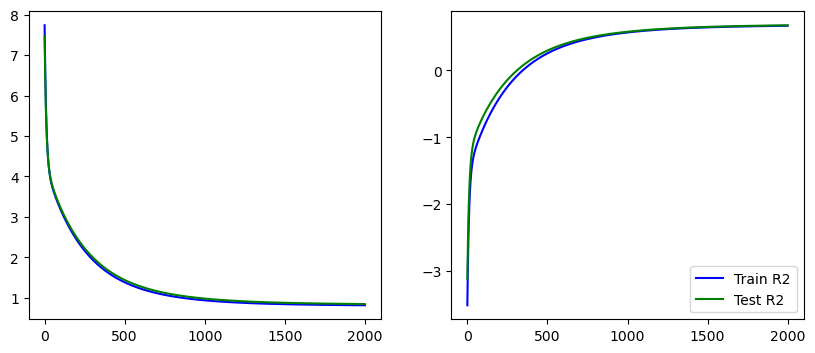

In [80]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

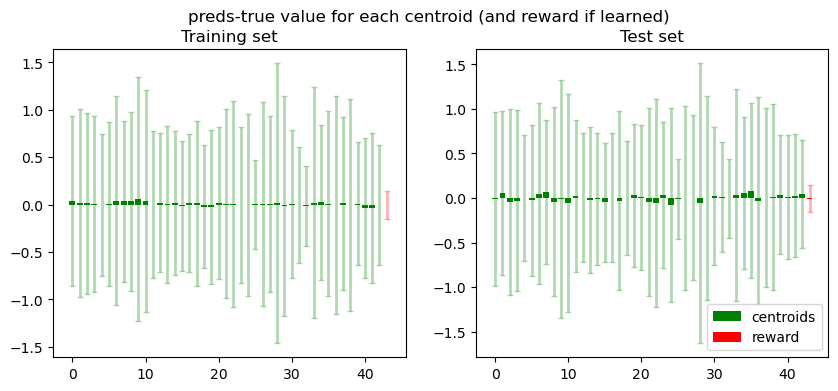

In [81]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = lr_model(train_x)
    test_preds = lr_model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

With model trainer

In [83]:
from typing import Callable, List, Optional, Tuple

from src.util.model_trainer import ModelTrainerOverriden
from mbrl.util.logger import Logger
from mbrl.util.replay_buffer import TransitionIterator

class SimpleModelTrainer(ModelTrainerOverriden):
    def __init__(self, 
        model: Model,
        criterion,
        metric,
        optim_lr: float = 0.0001, 
        weight_decay: float = 0., 
        optim_eps: float = 1e-8, 
        logger: Optional[Logger] = None):
        super().__init__(model, optim_lr, weight_decay, optim_eps, logger)
        self.metric = metric
        self.criterion = criterion

        self.optimizer = torch.optim.SGD(
            self.model.model.parameters(),
            lr=optim_lr,
        )

    def train(
            self, 
            train_x,
            train_y,
            test_x,
            test_y,
            num_epochs: Optional[int] = None, 
            ) -> Tuple[List[float], List[float]]:

            train_losses = []
            test_losses = []
            train_metrics = []
            test_metrics = []
            for epoch in range(num_epochs):
                # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
                self.optimizer.zero_grad()

                # get output from the model, given the inputs
                outputs = self.model.model(train_x)

                # get loss for the predicted output
                loss = self.criterion(outputs, train_y)
                train_losses.append(loss.item())
                # get gradients w.r.t to parameters
                loss.backward()

                # update parameters
                self.optimizer.step()

                # Compute metric
                train_metric = self.metric(outputs, train_y)
                train_metrics.append(train_metric.item())

                print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

                if epoch%eval_epoch_freq==0:
                    with torch.no_grad():
                        preds = self.model.model(test_x)
                        test_loss = self.criterion(preds, test_y)
                        test_losses.append(test_loss.item())
                        test_metric = self.metric(preds, test_y)
                        test_metrics.append(test_metric.item())
                        print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))
            
            return train_losses, test_losses, train_metrics, test_metrics

    # def train(
    #         self, 
    #         dataset_train: TransitionIterator, 
    #         dataset_val: Optional[TransitionIterator] = None, 
    #         num_epochs: Optional[int] = None, 
    #     ) -> Tuple[List[float], List[float]]:

    #     eval_dataset = dataset_train if dataset_val is None else dataset_val
    #     train_losses = []
    #     test_losses = []
    #     train_metrics = []
    #     test_metrics = []
    #     for epoch in range(num_epochs):
    #         batch_losses = []
    #         batch_metric = []
    #         for batch_train in dataset_train:
    #             print("Batch train", epoch, batch_train.obs.shape)
    #             train_x, train_y = self.model._process_batch(batch_train)
    #             # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    #             self.optimizer.zero_grad()

    #             # get output from the model, given the inputs
    #             outputs = self.model.model(train_x)

    #             # get loss for the predicted output
    #             loss = self.criterion(outputs, train_y)
    #             batch_losses.append(loss.item())
    #             # get gradients w.r.t to parameters
    #             loss.backward()

    #             # update parameters
    #             self.optimizer.step()

    #             # Compute metric
    #             train_metric = self.metric(outputs, train_y)
    #             batch_metric.append(train_metric.item())
            
    #         #Epoch loss and metric
    #         train_losses.append(np.mean(batch_losses))
    #         train_metrics.append(np.mean(batch_metric))

    #         print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    #         if epoch%eval_epoch_freq==0:
    #             with torch.no_grad():
    #                 batch_test_loss = []
    #                 batch_test_metric = []
    #                 for batch in eval_dataset:
    #                     print("Batch test", epoch, batch.obs.shape)
    #                     test_x, test_y = self.model._process_batch(batch)
    #                     preds = self.model.model(test_x)
    #                     test_loss = self.criterion(preds, test_y)
    #                     batch_test_loss.append(test_loss.item())
    #                     test_metric = self.metric(preds, test_y)
    #                     batch_test_metric.append(test_metric.item())
    #                 test_losses.append(np.mean(batch_test_loss))
    #                 test_metrics.append(np.mean(batch_test_metric))
    #                 print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))
        
    #     return train_losses, test_losses, train_metrics, test_metrics

In [84]:

#TEST with model trainer
import omegaconf

from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace
from src.util.model_trainer import ModelTrainerOverriden
from src.util.replay_buffer import ReplayBufferOverriden
import mbrl.util.common
from mbrl.util.replay_buffer import BootstrapIterator

#WARNING: Make sure that it makes sense with trained model above

#Env config
env_config = {
    "num_trucks": 5, #10
    "action_per_day": 8,
    "next_day_method": "random", #sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    #"centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None, #src/env/bikes_data/factors_radius_3.npy
}

#Params
seed = 1
device = "cpu"
target_is_delta = False
normalize = False
use_double_dtype = False #True
optim_lr=learningRate
model_wd=0
model_batch_size=dataset_size
validation_ratio=test_split_ratio
num_epochs=epochs

#Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(
    env_config,
    render_mode=None
)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

#Seed
# rng = np.random.default_rng(seed=seed)
# torch_generator = torch.Generator(device=device)
# if seed is not None:
#     torch_generator.manual_seed(seed)
rng = np.random.default_rng(seed=0)
torch.manual_seed(0)

#Dynamics model
dynamics_model = OneDTransitionRewardModelDictSpace(
    linearRegression(in_size, out_size, device),
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

#Model trainer
model_trainer = SimpleModelTrainer(
    criterion=criterion,
    metric=metric,
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)

#Load replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    dataset_size,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    #max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=dataset_size)

data = replay_buffer.get_all(shuffle=False)
val_size = int(replay_buffer.num_stored * validation_ratio)
train_size = replay_buffer.num_stored - val_size
train_data = data[:train_size]
dataset_train = BootstrapIterator(
    train_data,
    model_batch_size,
    ensemble_size=1,
    shuffle_each_epoch=False,
    permute_indices=False,
    rng=replay_buffer.rng,
)
val_iter = None
if val_size > 0:
    val_data = data[train_size:]
    dataset_val = TransitionIterator(
        val_data, model_batch_size, shuffle_each_epoch=False, rng=replay_buffer.rng
    )

# if hasattr(dynamics_model, "update_normalizer"):
#     dynamics_model.update_normalizer(replay_buffer.get_all())
train_losses, test_losses, train_metrics, test_metrics = model_trainer.train(
    train_x,
    train_y,
    test_x,
    test_y,
    num_epochs=num_epochs,
)


epoch 0, loss 7.345428943634033, R2 -1.9806392192840576
Eval loss 7.059577941894531, R2 -1.7640007734298706
epoch 1, loss 7.053285598754883, R2 -1.9037600755691528
Eval loss 6.797088146209717, R2 -1.6956852674484253
epoch 2, loss 6.787016868591309, R2 -1.8333964347839355
Eval loss 6.557851791381836, R2 -1.6331729888916016
epoch 3, loss 6.5442280769348145, R2 -1.768945336341858
Eval loss 6.339709281921387, R2 -1.5759263038635254
epoch 4, loss 6.322741985321045, R2 -1.7098610401153564
Eval loss 6.140703201293945, R2 -1.5234566926956177
epoch 5, loss 6.12058687210083, R2 -1.6556473970413208
Eval loss 5.959055423736572, R2 -1.475321888923645
epoch 6, loss 5.935973167419434, R2 -1.6058545112609863
Eval loss 5.793155670166016, R2 -1.4311199188232422
epoch 7, loss 5.767276287078857, R2 -1.5600749254226685
Eval loss 5.641541957855225, R2 -1.3904869556427002
epoch 8, loss 5.613024711608887, R2 -1.5179381370544434
Eval loss 5.502887725830078, R2 -1.3530926704406738
epoch 9, loss 5.47188186645507

<Figure size 640x480 with 0 Axes>

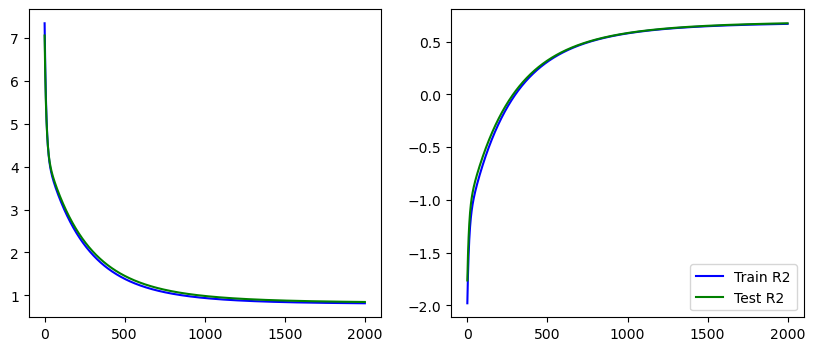

In [85]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

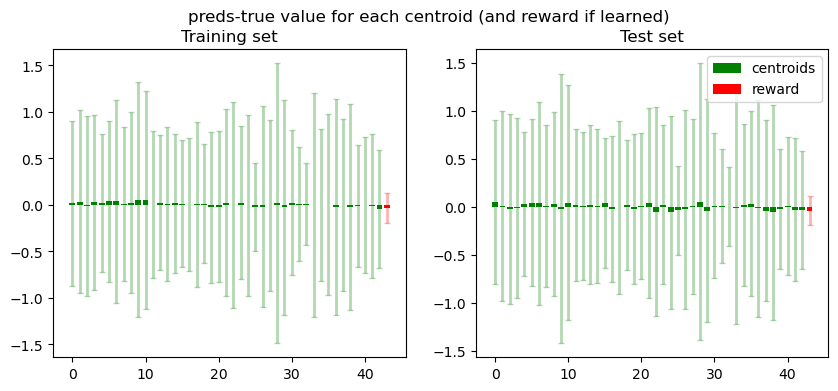

In [27]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = lr_model(train_x)
    test_preds = lr_model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

Neural Network

In [159]:
from src.model.simple import Simple

#Hyperparams
learningRate = 0.001
weight_decay = 0
optim_eps = 1e-8

epochs = 500
batch_size = 256
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
NN_model = Simple(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.Adam(
                NN_model.parameters(),
                lr=learningRate,
                weight_decay=weight_decay,
                eps=optim_eps,
            )
#torch.optim.SGD(model.parameters(), lr=learningRate)

In [160]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    k = 0
    l = batch_size
    batch_loss = []
    while l < train_x.shape[0]:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = NN_model(train_x)

        # get loss for the predicted output
        loss = criterion(outputs, train_y)
        batch_loss.append(loss.item())
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        #Update k,l
        k = l
        l = min(l+batch_size, train_x.shape[0])

    #Append train loss
    train_losses.append(np.mean(batch_loss))

    #Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(): # we don't need gradients in the testing phase
            preds = NN_model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            #Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))

epoch 0, loss 5.323896408081055, R2 -0.4018963575363159
Eval loss 5.323896408081055, R2 -0.40800949931144714
epoch 1, loss 4.939913272857666, R2 -0.25594255328178406
Eval loss 4.939913272857666, R2 -0.18786725401878357
epoch 2, loss 3.9092791080474854, R2 -0.16295231878757477
Eval loss 3.9092791080474854, R2 -0.604037344455719
epoch 3, loss 3.834420680999756, R2 -0.7803119421005249
Eval loss 3.834420680999756, R2 -0.4473435580730438
epoch 4, loss 3.371290445327759, R2 0.05224437639117241
Eval loss 3.371290445327759, R2 0.07332278043031693
epoch 5, loss 3.4254508018493652, R2 0.06424520909786224
Eval loss 3.4254508018493652, R2 0.05064111575484276
epoch 6, loss 3.348079204559326, R2 0.045901037752628326
Eval loss 3.348079204559326, R2 0.02455156482756138
epoch 7, loss 3.3848602771759033, R2 0.025363124907016754
Eval loss 3.3848602771759033, R2 0.016881713643670082
epoch 8, loss 3.3062312602996826, R2 0.046125736087560654
Eval loss 3.3062312602996826, R2 0.04103560000658035
epoch 9, loss

<Figure size 640x480 with 0 Axes>

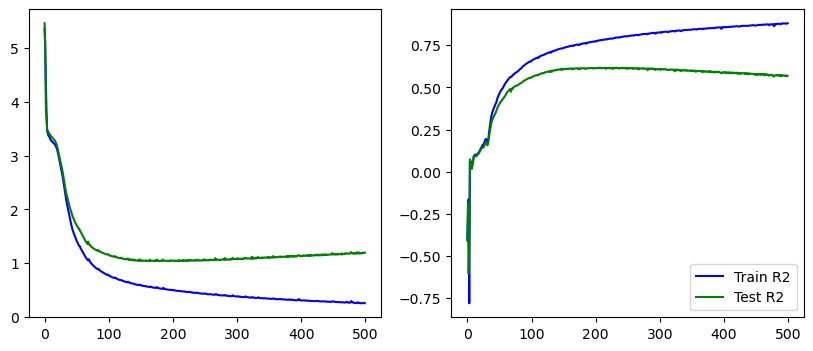

In [161]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

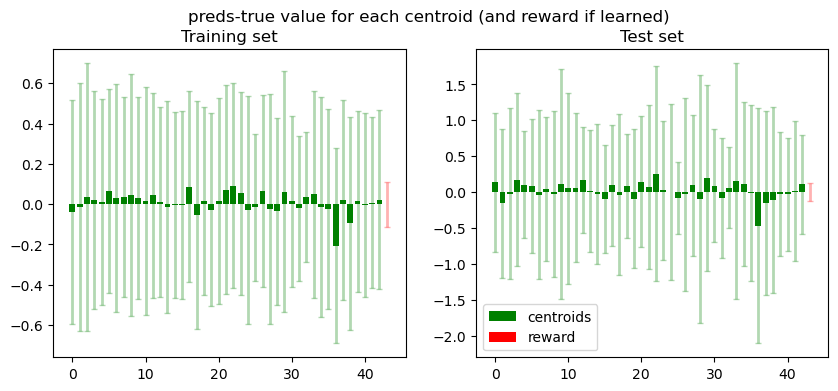

In [162]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = NN_model(train_x)
    test_preds = NN_model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

Gaussian process

In [163]:
from src.model.gaussian_process import MultiOutputGP

#Hyperparams
learningRate = 0.1
weight_decay = 0
optim_eps = 1e-8
mean = "Linear"
kernel = "Linear"

epochs = 50
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
GP_model = MultiOutputGP(in_size, out_size, device, mean, kernel)
mll = gpytorch.mlls.SumMarginalLogLikelihood(GP_model.likelihood, GP_model.gp)
metric = r2_score
optimizer = torch.optim.Adam(
                GP_model.parameters(),
                lr=learningRate,
                weight_decay=weight_decay,
                eps=optim_eps,
            )
#torch.optim.SGD(model.parameters(), lr=learningRate)

dataset_size_gp = 1000
gp_idx_split = int(test_split_ratio*dataset_size_gp)

train_x_gp = train_x[gp_idx_split:dataset_size_gp, ...]
train_y_gp = train_y[gp_idx_split:dataset_size_gp, ...]
test_x_gp = test_x[:gp_idx_split, ...]
test_y_gp = test_y[:gp_idx_split, ...]

print(train_x_gp.shape, train_y_gp.shape, test_x_gp.shape, test_y_gp.shape)

torch.Size([600, 44]) torch.Size([600, 44]) torch.Size([200, 44]) torch.Size([200, 44])


In [164]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    #Set training mode REQUIRED FOR GP
    GP_model.gp.train()

    #Set the training data
    if epoch==0:
        GP_model.set_train_data(train_x_gp, train_y_gp)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = GP_model.forward()

    # get loss for the predicted output
    loss = -mll(outputs, GP_model.gp.train_targets)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #Compute metric
    train_pred_output = GP_model.likelihood(*outputs)
    train_pred_mean = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_pred_output], axis=-1
    )
    train_metric = metric(train_pred_mean, train_y_gp)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            GP_model.gp.eval()
            GP_model.likelihood.eval()
            preds = GP_model.forward(test_x_gp)
            test_loss = -mll(preds, [test_y_gp[..., i] for i in range(len(GP_model.gp.models))])
            test_losses.append(test_loss.item())
            #Compute metric
            test_pred_output = GP_model.likelihood(*preds)
            test_pred_mean = torch.cat(
                [pred.mean.unsqueeze(-1) for pred in test_pred_output], axis=-1
            )
            test_metric = metric(test_pred_mean, test_y_gp)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(loss.item(), test_metric))

epoch 0, loss 1.665695071220398, R2 -193.2993621826172
Eval loss 1.665695071220398, R2 0.3234846889972687
epoch 1, loss 1.6216813325881958, R2 -172.3352508544922
Eval loss 1.6216813325881958, R2 0.3712581694126129
epoch 2, loss 1.5875122547149658, R2 -147.14016723632812
Eval loss 1.5875122547149658, R2 0.41509801149368286
epoch 3, loss 1.560895562171936, R2 -124.4258041381836
Eval loss 1.560895562171936, R2 0.4552282989025116
epoch 4, loss 1.539678931236267, R2 -105.1559829711914
Eval loss 1.539678931236267, R2 0.49158209562301636
epoch 5, loss 1.5222197771072388, R2 -89.65971374511719
Eval loss 1.5222197771072388, R2 0.5242920517921448
epoch 6, loss 1.5074580907821655, R2 -77.09456634521484
Eval loss 1.5074580907821655, R2 0.5532590746879578
epoch 7, loss 1.4947861433029175, R2 -66.50433349609375
Eval loss 1.4947861433029175, R2 0.5786527991294861
epoch 8, loss 1.4837571382522583, R2 -57.077491760253906
Eval loss 1.4837571382522583, R2 0.6005467772483826
epoch 9, loss 1.47398459911346

<Figure size 640x480 with 0 Axes>

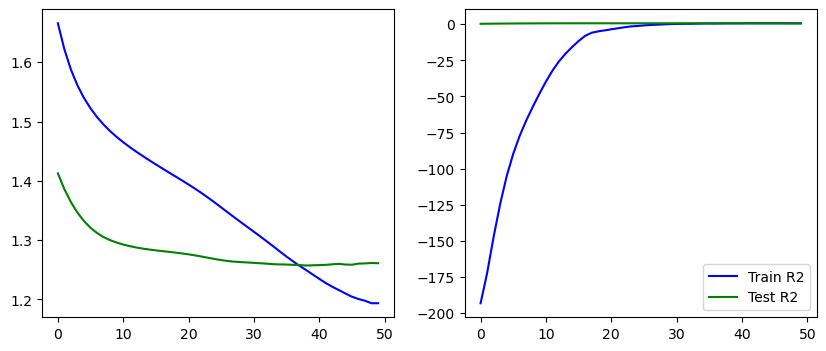

In [165]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

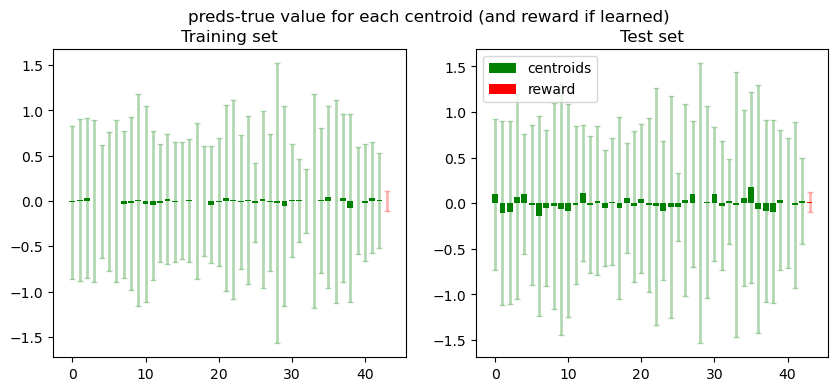

In [166]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_preds = GP_model.likelihood(*GP_model(train_x_gp))
    test_preds = GP_model.likelihood(*GP_model(test_x_gp))
    train_preds = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_preds], axis=-1
    )
    test_preds = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in test_preds], axis=-1
    )

relative_train_preds_mean = torch.mean(train_preds - train_y_gp, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y_gp, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y_gp, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y_gp, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

In [167]:
gp_id = 0

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = GP_model.likelihood.likelihoods[gp_id](GP_model.gp.models[gp_id](train_x_gp))
    test_pred = GP_model.likelihood.likelihoods[gp_id](GP_model.gp.models[gp_id](test_x_gp))

    train_lower, train_upper = train_pred.confidence_region()
    mean_lower_train = np.mean(train_lower.numpy()-train_pred.mean.numpy())
    std_lower_train = np.std(train_lower.numpy()-train_pred.mean.numpy())
    mean_upper_train = np.mean(train_upper.numpy()-train_pred.mean.numpy())
    std_upper_train = np.std(train_upper.numpy()-train_pred.mean.numpy())
    test_lower, test_upper = test_pred.confidence_region()
    mean_lower_test = np.mean(test_lower.numpy()-test_pred.mean.numpy())
    std_lower_test = np.std(test_lower.numpy()-test_pred.mean.numpy())
    mean_upper_test = np.mean(test_upper.numpy()-test_pred.mean.numpy())
    std_upper_test = np.std(test_upper.numpy()-test_pred.mean.numpy())

    print(train_pred.mean.numpy().shape, test_pred.mean.numpy().shape)
    print(f"Lower train: {mean_lower_train}+-{std_lower_train}")
    print(f"Upper train: {mean_upper_train}+-{std_upper_train}")
    print(f"Lower train: {mean_lower_test}+-{std_lower_test}")
    print(f"Lower train: {mean_upper_test}+-{std_upper_test}")

(600,) (200,)
Lower train: -1.8210667371749878+-0.01887916587293148
Upper train: 1.8210667371749878+-0.01887916401028633
Lower train: -1.8232992887496948+-0.018743911758065224
Lower train: 1.8232992887496948+-0.01874392479658127


### 3. The MBRL agent

Parameters

In [51]:
import omegaconf

import mbrl
import mbrl.models
import mbrl.planning
from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace

#WARNING: Make sure that it makes sense with trained model above

#Env config
env_config = {
    "num_trucks": 5, #10
    "action_per_day": 8,
    "next_day_method": "random", #sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    #"centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None, #src/env/bikes_data/factors_radius_3.npy
}

#Params
seed = 0
device = "cpu"
num_episodes = 10
num_steps = num_episodes*env_config["action_per_day"]
initial_exploration_steps = 500
target_is_delta = False
normalize = False
use_double_dtype = False #True
num_particles = 20

#Agent config
optimizer_cfg = {
    "_target_": "mbrl.planning.CEMOptimizer",
    "num_iterations": 5,
    "elite_ratio": 0.1,
    "population_size": 350,
    "alpha": 0.1,
    "lower_bound": None,
    "upper_bound": None,
    "return_mean_elites": True,
    "device": device,
    "clipped_normal": False,
}


The important building blocks

In [52]:
#Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(
    env_config,
    render_mode=None
)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
print(obs_shape, act_shape)

#Seed
rng = np.random.default_rng(seed=seed)
torch_generator = torch.Generator(device=device)
if seed is not None:
    torch_generator.manual_seed(seed)

#Dynamics model
model = lr_model

dynamics_model = OneDTransitionRewardModelDictSpace(
    model,
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

#Model Env
model_env = mbrl.models.ModelEnv(
    env, dynamics_model, env.termination_fn, None, generator=torch_generator
)

#Agent
optimizer_cfg = omegaconf.DictConfig(optimizer_cfg)
agent = mbrl.planning.TrajectoryOptimizerAgent(
    optimizer_cfg=optimizer_cfg,
    action_lb=env.action_space.low,
    action_ub=env.action_space.high,
    planning_horizon=env.action_per_day,
    replan_freq=1,
)
def trajectory_eval_fn(initial_state, action_sequences):
    return model_env.evaluate_action_sequences(
        action_sequences, initial_state=initial_state, num_particles=num_particles
    )
agent.set_trajectory_eval_fn(trajectory_eval_fn)


(46,) (10,)


RL loop (with pretrained model)

In [55]:
import warnings
warnings.filterwarnings("ignore")

env_steps = 0
current_trial = 0
rewards = np.empty((num_episodes, env_config["action_per_day"]))

while (
    current_trial < num_episodes
):
    obs, _ = env.reset()
    agent.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    # Make 1 episode
    while not terminated and not truncated:

        # --- Doing env step using the agent ---
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        rewards[current_trial, steps_trial] = reward

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        env_steps += 1
        
        #print(f"Step {env_steps}: Reward {reward:.3f}.")

    current_trial += 1
    print(f"Trial: {current_trial }, reward: {total_reward}.")

Trial: 1, reward: 2.573672088377971.
Trial: 2, reward: 2.705402098585997.
Trial: 3, reward: 2.322563968184047.
Trial: 4, reward: 2.677491420881591.
Trial: 5, reward: 2.8242376956986925.
Trial: 6, reward: 3.101734248162826.
Trial: 7, reward: 1.843696885892893.
Trial: 8, reward: 1.903616935018447.
Trial: 9, reward: 2.8298462815498127.
Trial: 10, reward: 2.7504850048228.


Text(0, 0.5, 'Cumulative Reward')

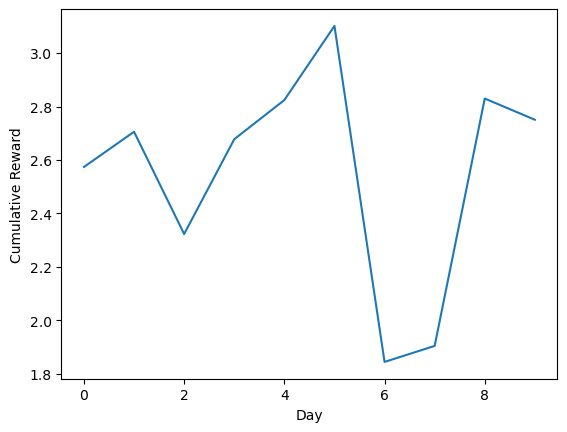

In [56]:
plt.plot(np.sum(rewards, axis=-1))
plt.xlabel('Day'); plt.ylabel('Cumulative Reward')

### 4. Training MBRL agent with a pretrained model

Parameters

In [65]:
from typing import Optional
import omegaconf

import mbrl
import mbrl.models
import mbrl.planning
from mbrl.models.model import Model
from mbrl.util.logger import Logger
import mbrl.util.common
import mbrl.models

from src.util.replay_buffer import ReplayBufferOverriden
from src.util.model_trainer import ModelTrainer, ModelTrainerOverriden
from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace

#WARNING: Make sure that it makes sense with trained model above

#Env config
env_config = {
    "num_trucks": 5, #10
    "action_per_day": 8,
    "next_day_method": "random", #sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    #"centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None, #src/env/bikes_data/factors_radius_3.npy
}

#Params
seed = 0
device = "cpu"
num_episodes = 20
num_steps = num_episodes*env_config["action_per_day"]
initial_exploration_steps = 500
target_is_delta = False
normalize = False
use_double_dtype = False #True
num_particles = 20
optim_lr = 0.1
model_wd = 0
freq_train_model = 10
model_batch_size = num_steps+initial_exploration_steps #Make sense for LR or GP
validation_ratio = 0
num_epochs = 100

#Agent config
optimizer_cfg = {
    "_target_": "mbrl.planning.CEMOptimizer",
    "num_iterations": 5,
    "elite_ratio": 0.1,
    "population_size": 350,
    "alpha": 0.1,
    "lower_bound": None,
    "upper_bound": None,
    "return_mean_elites": True,
    "device": device,
    "clipped_normal": False,
}

Important building blocks

In [67]:
#Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(
    env_config,
    render_mode=None
)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
print(obs_shape, act_shape)

#Seed
rng = np.random.default_rng(seed=seed)
torch_generator = torch.Generator(device=device)
if seed is not None:
    torch_generator.manual_seed(seed)

#Dynamics model
model = lr_model

dynamics_model = OneDTransitionRewardModelDictSpace(
    model,
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

#Model Env
model_env = mbrl.models.ModelEnv(
    env, dynamics_model, env.termination_fn, None, generator=torch_generator
)

#Agent
optimizer_cfg = omegaconf.DictConfig(optimizer_cfg)
agent = mbrl.planning.TrajectoryOptimizerAgent(
    optimizer_cfg=optimizer_cfg,
    action_lb=env.action_space.low,
    action_ub=env.action_space.high,
    planning_horizon=env.action_per_day,
    replan_freq=1,
)
def trajectory_eval_fn(initial_state, action_sequences):
    return model_env.evaluate_action_sequences(
        action_sequences, initial_state=initial_state, num_particles=num_particles
    )
agent.set_trajectory_eval_fn(trajectory_eval_fn)

#Model trainer
model_trainer = ModelTrainerOverriden(
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)


#Replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    num_steps+initial_exploration_steps,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    #max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=initial_exploration_steps)

(46,) (10,)


Training MBRL loop

In [68]:
import warnings
warnings.filterwarnings("ignore")

env_steps = 0
current_trial = 0
rewards = np.empty((num_episodes, env_config["action_per_day"]))
all_training_losses = []
all_val_scores = []

while current_trial < num_episodes:
    obs, _ = env.reset()
    agent.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    # Make 1 episode
    while not terminated and not truncated:
        # --------------- Model Training -----------------
        if env_steps % freq_train_model == 0:
            dataset_train, dataset_val = mbrl.util.common.get_basic_buffer_iterators(
                replay_buffer,
                model_batch_size,
                validation_ratio,
                ensemble_size=len(dynamics_model),
                shuffle_each_epoch=True,
                bootstrap_permutes=False,
            )
            if hasattr(dynamics_model, "update_normalizer"):
                dynamics_model.update_normalizer(replay_buffer.get_all())
            training_losses, val_scores = model_trainer.train(
                dataset_train,
                dataset_val=dataset_val,
                num_epochs=num_epochs,
                patience=num_epochs,
                improvement_threshold=0.01,
            )
            all_training_losses += training_losses
            all_val_scores += val_scores
            print(f"Mean train loss: {np.mean(training_losses):.3f} Mean val score: {np.mean(val_scores):.3f}")

        # --- Doing env step using the agent and adding to model dataset ---
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        replay_buffer.add(obs, action, next_obs, reward, terminated, truncated)

        model_action = action[None, ...]
        model_observation = {
            "obs": obs[None, ...],
            "propagation_indices": None,
        }
        model_next_obs, model_reward, model_dones, next_model_state = model_env.step(model_action, model_observation)
        #TODO: compare actual next_obs and rewards with model env
        print(next_obs-torch.round(model_next_obs).numpy(), reward-model_reward.numpy(), terminated)

        rewards[current_trial, steps_trial] = reward

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        env_steps += 1

        print(f"Step {env_steps}: Reward {reward:.3f}.")

    current_trial += 1
    print(f"Trial: {current_trial }, reward: {total_reward}.")


1 500
Epoch: 0 Train loss 4.989, Test loss 4.970
1 500
Epoch: 1 Train loss 4.970, Test loss 4.952
1 500
Epoch: 2 Train loss 4.952, Test loss 4.934
1 500
Epoch: 3 Train loss 4.934, Test loss 4.916
1 500
Epoch: 4 Train loss 4.916, Test loss 4.898
1 500
Epoch: 5 Train loss 4.898, Test loss 4.880
1 500
Epoch: 6 Train loss 4.880, Test loss 4.863
1 500
Epoch: 7 Train loss 4.863, Test loss 4.846
1 500
Epoch: 8 Train loss 4.846, Test loss 4.829
1 500
Epoch: 9 Train loss 4.829, Test loss 4.812
1 500
Epoch: 10 Train loss 4.812, Test loss 4.795
1 500
Epoch: 11 Train loss 4.795, Test loss 4.779
1 500
Epoch: 12 Train loss 4.779, Test loss 4.763
1 500
Epoch: 13 Train loss 4.763, Test loss 4.746
1 500
Epoch: 14 Train loss 4.746, Test loss 4.731
1 500
Epoch: 15 Train loss 4.731, Test loss 4.715
1 500
Epoch: 16 Train loss 4.715, Test loss 4.699
1 500
Epoch: 17 Train loss 4.699, Test loss 4.684
1 500
Epoch: 18 Train loss 4.684, Test loss 4.669
1 500
Epoch: 19 Train loss 4.669, Test loss 4.654
1 500
Epoc

Epoch: 67 Train loss 4.108, Test loss 4.099
1 500
Epoch: 68 Train loss 4.099, Test loss 4.090
1 500
Epoch: 69 Train loss 4.090, Test loss 4.082
1 500
Epoch: 70 Train loss 4.082, Test loss 4.073
1 500
Epoch: 71 Train loss 4.073, Test loss 4.065
1 500
Epoch: 72 Train loss 4.065, Test loss 4.056
1 500
Epoch: 73 Train loss 4.056, Test loss 4.048
1 500
Epoch: 74 Train loss 4.048, Test loss 4.040
1 500
Epoch: 75 Train loss 4.040, Test loss 4.032
1 500
Epoch: 76 Train loss 4.032, Test loss 4.024
1 500
Epoch: 77 Train loss 4.024, Test loss 4.016
1 500
Epoch: 78 Train loss 4.016, Test loss 4.008
1 500
Epoch: 79 Train loss 4.008, Test loss 4.001
1 500
Epoch: 80 Train loss 4.001, Test loss 3.993
1 500
Epoch: 81 Train loss 3.993, Test loss 3.985
1 500
Epoch: 82 Train loss 3.985, Test loss 3.978
1 500
Epoch: 83 Train loss 3.978, Test loss 3.971
1 500
Epoch: 84 Train loss 3.971, Test loss 3.963
1 500
Epoch: 85 Train loss 3.963, Test loss 3.956
1 500
Epoch: 86 Train loss 3.956, Test loss 3.949
1 500


<Figure size 640x480 with 0 Axes>

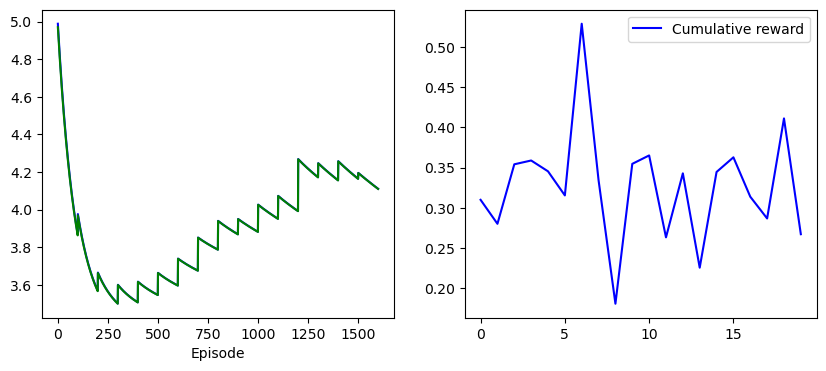

In [69]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(all_training_losses, 'b', label='Training loss')
ax[0].plot(all_val_scores, 'g', label='Eval score')
ax[0].set_xlabel('train epoch')
ax[1].plot(np.mean(rewards, axis=-1), 'b', label='Cumulative reward')
ax[0].set_xlabel('Episode')
plt.legend(loc='best')
plt.show()